In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from decifer.utility import pxrd_from_cif

def plot_validity_rwp_dual_axis_aggregate(results, param_name, prefix=""):
    """
    Aggregate experiment metrics over all entries that share the same parameter value (e.g. particle_size)
    and plot Validity (%) and RWP on the same plot using dual y-axes and fill_between to show variability.
    
    Args:
        results (dict): The experiment results dictionary.
        param_name (str): The parameter name to aggregate and plot (e.g., "particle_size").
    """
    # Aggregate metrics by the parameter value.
    aggregated = {}
    for combo_key, exp_list in results.items():
        for exp in exp_list:
            param_val = exp["params"][param_name]
            if param_val not in aggregated:
                aggregated[param_val] = {"valid": [], "rwp": []}
            # Validity as percentage: 100 if valid, 0 otherwise.
            aggregated[param_val]["valid"].append(100 * (1 if exp["val"] else 0))
            aggregated[param_val]["rwp"].append(exp["rwp"])
    
    # Sort the parameter values.
    sorted_param_vals = sorted(aggregated.keys())
    validity_means = []
    validity_stds = []
    rwp_means = []
    rwp_stds = []
    for val in sorted_param_vals:
        valid_vals = np.array(aggregated[val]["valid"])
        rwp_vals = np.array(aggregated[val]["rwp"])
        validity_means.append(np.mean(valid_vals))
        validity_stds.append(np.std(valid_vals))
        rwp_means.append(np.mean(rwp_vals))
        rwp_stds.append(np.std(rwp_vals))
    
    sorted_param_vals = np.array(sorted_param_vals)
    validity_means = np.array(validity_means)
    validity_stds = np.array(validity_stds)
    rwp_means = np.array(rwp_means)
    rwp_stds = np.array(rwp_stds)
    
    # Create dual y-axis plot.
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    
    # Plot Validity on the left y-axis.
    ax1.plot(sorted_param_vals, validity_means, 'o-', color='blue', label="Validity (%)")
    ax1.fill_between(sorted_param_vals, validity_means - validity_stds, validity_means + validity_stds,
                     color='blue', alpha=0.3)
    ax1.set_xlabel(param_name)
    ax1.set_ylabel("Validity (%)", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    
    # Plot RWP on the right y-axis.
    ax2.plot(sorted_param_vals, rwp_means, 'o-', color='green', label="RWP")
    ax2.fill_between(sorted_param_vals, rwp_means - rwp_stds, rwp_means + rwp_stds,
                     color='green', alpha=0.3)
    ax2.set_ylabel("RWP", color="green")
    ax2.tick_params(axis='y', labelcolor="green")
    
    # Combine legends.
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
    
    plt.title(f"Validity and RWP vs. {param_name} (Aggregated)")
    plt.tight_layout()
    plt.show()
    fig.savefig(f"{prefix}_validity_rwp.png")

def visualize_best_structures(results, param_name, standard_pxrd_params=None, prefix=""):
    """
    For each unique value of the chosen parameter, select the best experiment result 
    (lowest rwp), then visualize:
      - A textual summary of the reference and generated structures.
      - A PXRD comparison plot that overlays:
          (a) The PXRD computed with the experiment parameters, and
          (b) The PXRD computed with a fixed, standard set of parameters.
    
    Args:
        results (dict): The experiment results dictionary.
        param_name (str): The parameter name to group by (e.g., "particle_size").
        cif_sample (str): The reference CIF string (used to compute the standard PXRD for the reference).
        standard_pxrd_params (dict, optional): A dictionary of PXRD parameters to use for the standard PXRD.
    """
    if standard_pxrd_params is None:
        standard_pxrd_params = {
            "qmin": 0.0,
            "qmax": 10.0,
            "qstep": 0.01,
            "base_fwhm": 0.05,
            "eta": 0.5
        }
    
    # Aggregate best results per parameter value.
    best_results = {}
    for combo_key, exp_list in results.items():
        # Each experiment in exp_list shares the same value for param_name.
        param_val = exp_list[0]['params'][param_name]
        # Choose the result with highest peak_similarity.
        best_result = min(exp_list, key=lambda x: x['rwp'])
        best_results[param_val] = best_result

    # Sort the unique parameter values.
    sorted_param_vals = sorted(best_results.keys())
    
    for val in sorted_param_vals:
        res = best_results[val]
        
        # Build structure summaries.
        ref_struct = res["reference_structure"]
        gen_struct = res["generated_structure"]
        ref_summary = (
            f"Reference Structure:\n"
            f"Formula: {ref_struct.composition.reduced_formula}\n"
            f"Spacegroup: {ref_struct.get_space_group_info()[0]}"
        )
        gen_summary = (
            f"Generated Structure:\n"
            f"Formula: {gen_struct.composition.reduced_formula}\n"
            f"Spacegroup: {gen_struct.get_space_group_info()[0]}"
        )
        
        # Get the PXRD computed with the experiment parameters.
        pxrd_exp_ref = res["pxrd_ref"]
        pxrd_exp_gen = res["pxrd_gen"]
        
        # Compute standard PXRD for both reference and generated structure.
        pxrd_std_ref = pxrd_from_cif(res["reference_cif"], debug=True, **standard_pxrd_params)
        pxrd_std_gen = pxrd_from_cif(res["generated_cif"], debug=True, **standard_pxrd_params)
        
        # Create a figure with two subplots: one for structure summary and one for PXRD comparison.
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f"{param_name} = {val}  |  Rwp: {res['rwp']:.2f}", fontsize=16)
        
        # Subplot for structure summary.
        axs[0].axis("off")
        axs[0].text(0.5, 0.65, ref_summary, ha="center", va="center", fontsize=12,
                    bbox=dict(facecolor="lightgray", alpha=0.5))
        axs[0].text(0.5, 0.35, gen_summary, ha="center", va="center", fontsize=12,
                    bbox=dict(facecolor="lightblue", alpha=0.5))
        axs[0].set_title("Structure Comparison")
        
        # Subplot for PXRD comparison.
        # Plot the PXRD computed with experiment parameters.
        axs[1].plot(pxrd_exp_ref["q"], pxrd_exp_ref["iq"], label="Ref PXRD (Exp Params)", color="black", lw=2)
        axs[1].plot(pxrd_exp_gen["q"], pxrd_exp_gen["iq"], label="Gen PXRD (Exp Params)", color="red", lw=2)
        # Overlay the standard PXRD.
        axs[1].plot(pxrd_std_ref["q"], pxrd_std_ref["iq"], '--', label="Ref PXRD (Standard)", color="gray", lw=2)
        axs[1].plot(pxrd_std_gen["q"], pxrd_std_gen["iq"], '--', label="Gen PXRD (Standard)", color="orange", lw=2)
        axs[1].set_xlabel("q")
        axs[1].set_ylabel("Intensity")
        axs[1].set_title("PXRD Comparison")
        axs[1].legend(loc="best")
        
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()
        fig.savefig(f"{prefix}_{param_name}_{val}.png")

In [13]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from decifer.utility import pxrd_from_cif

def combined_analysis_and_visualization(result_path, param_name, standard_pxrd_params=None, prefix="", folder="figures"):
    
    # Load data
    with open(result_path, "rb") as f:
        data = pickle.load(f)
    results = data["results"]
    
    # Ensure the output folder exists.
    os.makedirs(folder, exist_ok=True)
    
    ##############################
    # Part 1: Dual-Axis Aggregated Plot (Validity and RWP)
    ##############################
    aggregated = {}
    for combo_key, exp_list in results.items():
        for exp in exp_list:
            param_val = exp["params"][param_name]
            if param_val not in aggregated:
                aggregated[param_val] = {"valid": [], "rwp": []}
            # Validity as percentage: 100 if valid, 0 otherwise.
            aggregated[param_val]["valid"].append(100 * (1 if exp["val"] else 0))
            aggregated[param_val]["rwp"].append(exp["rwp"])
    
    # Sort the parameter values and calculate statistics.
    sorted_param_vals = sorted(aggregated.keys())
    validity_means, validity_stds, rwp_means, rwp_stds = [], [], [], []
    for val in sorted_param_vals:
        valid_vals = np.array(aggregated[val]["valid"])
        rwp_vals = np.array(aggregated[val]["rwp"])
        validity_means.append(np.mean(valid_vals))
        validity_stds.append(np.std(valid_vals))
        rwp_means.append(np.mean(rwp_vals))
        rwp_stds.append(np.std(rwp_vals))
    
    sorted_param_vals = np.array(sorted_param_vals)
    validity_means = np.array(validity_means)
    validity_stds = np.array(validity_stds)
    rwp_means = np.array(rwp_means)
    rwp_stds = np.array(rwp_stds)
    
    # Create the dual y-axis plot.
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    ax1.plot(sorted_param_vals, validity_means, 'o-', color='blue', label="Validity (%)")
    ax1.fill_between(sorted_param_vals, validity_means - validity_stds, validity_means + validity_stds,
                     color='blue', alpha=0.3)
    ax1.set_xlabel(param_name)
    ax1.set_ylabel("Validity (%)", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    
    ax2.plot(sorted_param_vals, rwp_means, 'o-', color='green', label="RWP")
    ax2.fill_between(sorted_param_vals, rwp_means - rwp_stds, rwp_means + rwp_stds,
                     color='green', alpha=0.3)
    ax2.set_ylabel("RWP", color="green")
    ax2.tick_params(axis='y', labelcolor="green")
    
    # Combine legends from both axes.
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
    
    plt.title(f"Validity and RWP vs. {param_name} (Aggregated)")
    plt.tight_layout()
    plt.close()
    fig.savefig(os.path.join(folder, f"{prefix}_validity_rwp.png"))
    
    ##############################
    # Part 2: Best Structure Visualization
    ##############################
    if standard_pxrd_params is None:
        standard_pxrd_params = {
            "qmin": 0.0,
            "qmax": 10.0,
            "qstep": 0.01,
            "base_fwhm": 0.05,
            "eta": 0.5
        }
    
    # Select the best result (lowest rwp) for each unique parameter value.
    best_results = {}
    for combo_key, exp_list in results.items():
        param_val = exp_list[0]['params'][param_name]
        best_result = min(exp_list, key=lambda x: x['rwp'])
        best_results[param_val] = best_result
        
#     print(best_results)

    sorted_param_vals = sorted(best_results.keys())
    
#     print(sorted_param_vals)
    
    for val in sorted_param_vals:
        res = best_results[val]
        
        # Build textual summaries for reference and generated structures.
        ref_struct = res["reference_structure"]
        gen_struct = res["generated_structure"]
        ref_summary = (
            f"Reference Structure:\n"
            f"Formula: {ref_struct.composition.reduced_formula}\n"
            f"Spacegroup: {ref_struct.get_space_group_info()[0]}"
        )
        gen_summary = (
            f"Generated Structure:\n"
            f"Formula: {gen_struct.composition.reduced_formula}\n"
            f"Spacegroup: {gen_struct.get_space_group_info()[0]}"
        )
        
        # Retrieve the PXRD results computed with experiment parameters.
        pxrd_exp_ref = res["pxrd_ref"]
        pxrd_exp_gen = res["pxrd_gen"]
        
        # Compute the standard PXRD for both reference and generated structures.
        pxrd_std_ref = pxrd_from_cif(res["reference_cif"], debug=True, **standard_pxrd_params)
        pxrd_std_gen = pxrd_from_cif(res["generated_cif"], debug=True, **standard_pxrd_params)
        
        # Create a figure with two subplots: one for the structure summaries and one for the PXRD comparisons.
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f"{param_name} = {val}  |  Rwp: {res['rwp']:.2f}", fontsize=16)
        
        # Subplot for structure summaries.
        axs[0].axis("off")
        axs[0].text(0.5, 0.65, ref_summary, ha="center", va="center", fontsize=12,
                    bbox=dict(facecolor="lightgray", alpha=0.5))
        axs[0].text(0.5, 0.35, gen_summary, ha="center", va="center", fontsize=12,
                    bbox=dict(facecolor="lightblue", alpha=0.5))
        axs[0].set_title("Structure Comparison")
        
        # Subplot for PXRD comparison.
        axs[1].plot(pxrd_exp_ref["q"], pxrd_exp_ref["iq"], label="Ref PXRD (Exp Params)", color="black", lw=2)
        axs[1].plot(pxrd_exp_gen["q"], pxrd_exp_gen["iq"], label="Gen PXRD (Exp Params)", color="red", lw=2)
        axs[1].plot(pxrd_std_ref["q"], pxrd_std_ref["iq"], '--', label="Ref PXRD (Standard)", color="gray", lw=2)
        axs[1].plot(pxrd_std_gen["q"], pxrd_std_gen["iq"], '--', label="Gen PXRD (Standard)", color="orange", lw=2)
        axs[1].set_xlabel("q")
        axs[1].set_ylabel("Intensity")
        axs[1].set_title("PXRD Comparison")
        axs[1].legend(loc="best")
        
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()
        fig.savefig(os.path.join(folder, f"{prefix}_{param_name}_{val}.png"))


In [14]:
# combined_analysis_and_visualization("../experimental_results_comp.pkl", 
#                                     "particle_size", prefix="comp", folder="particle_size")
# combined_analysis_and_visualization("../experimental_results_compsg.pkl",
#                                     "particle_size", prefix="compsg", folder="particle_size")

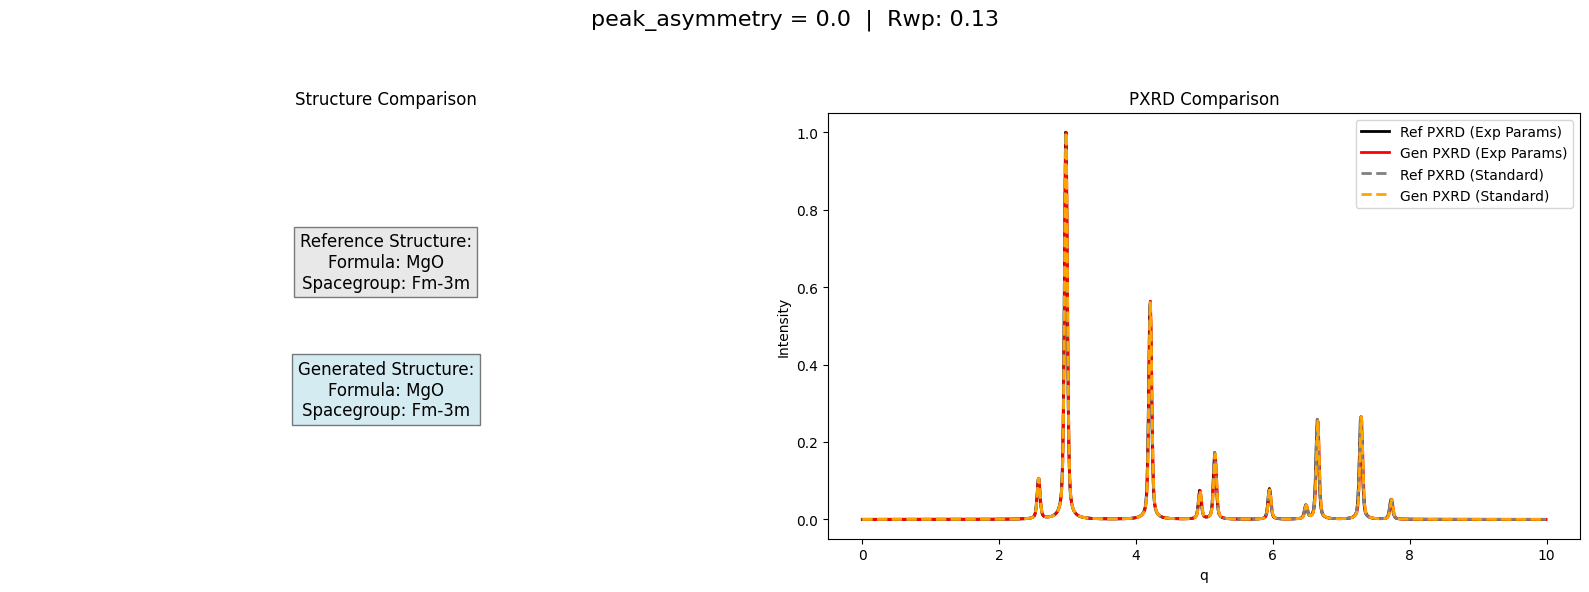

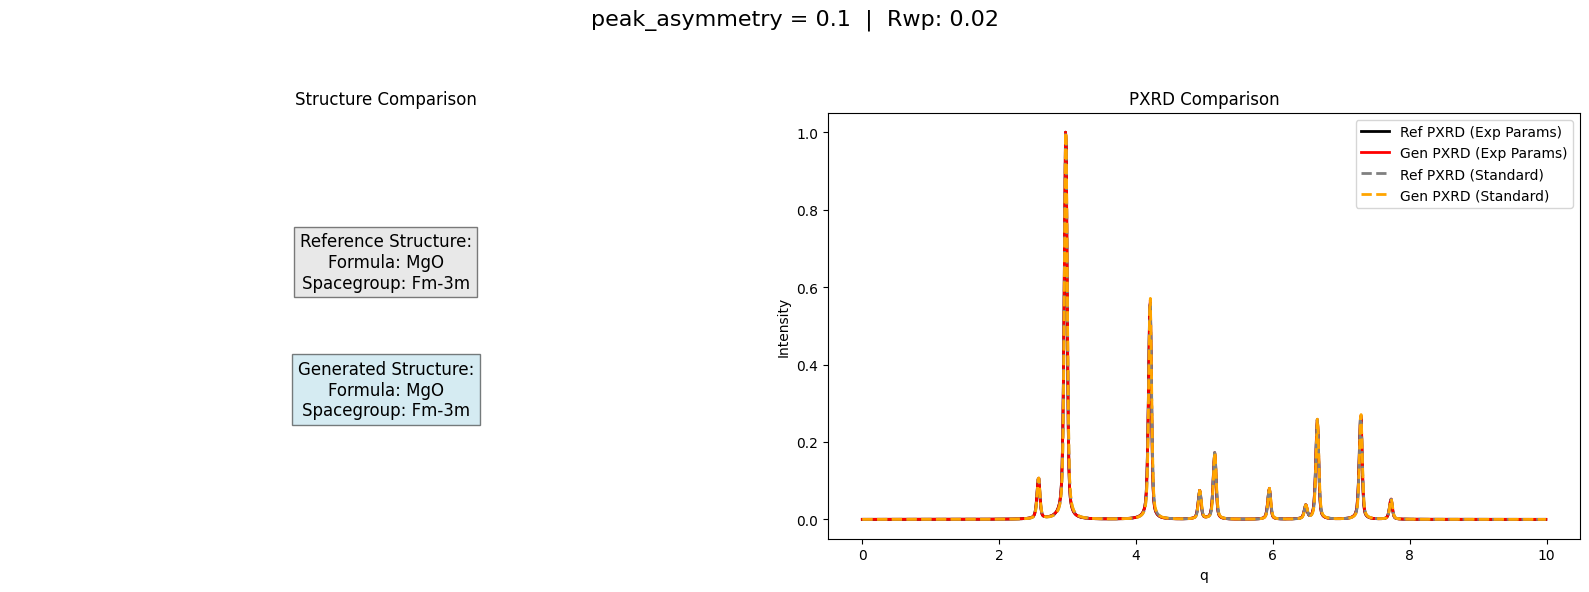

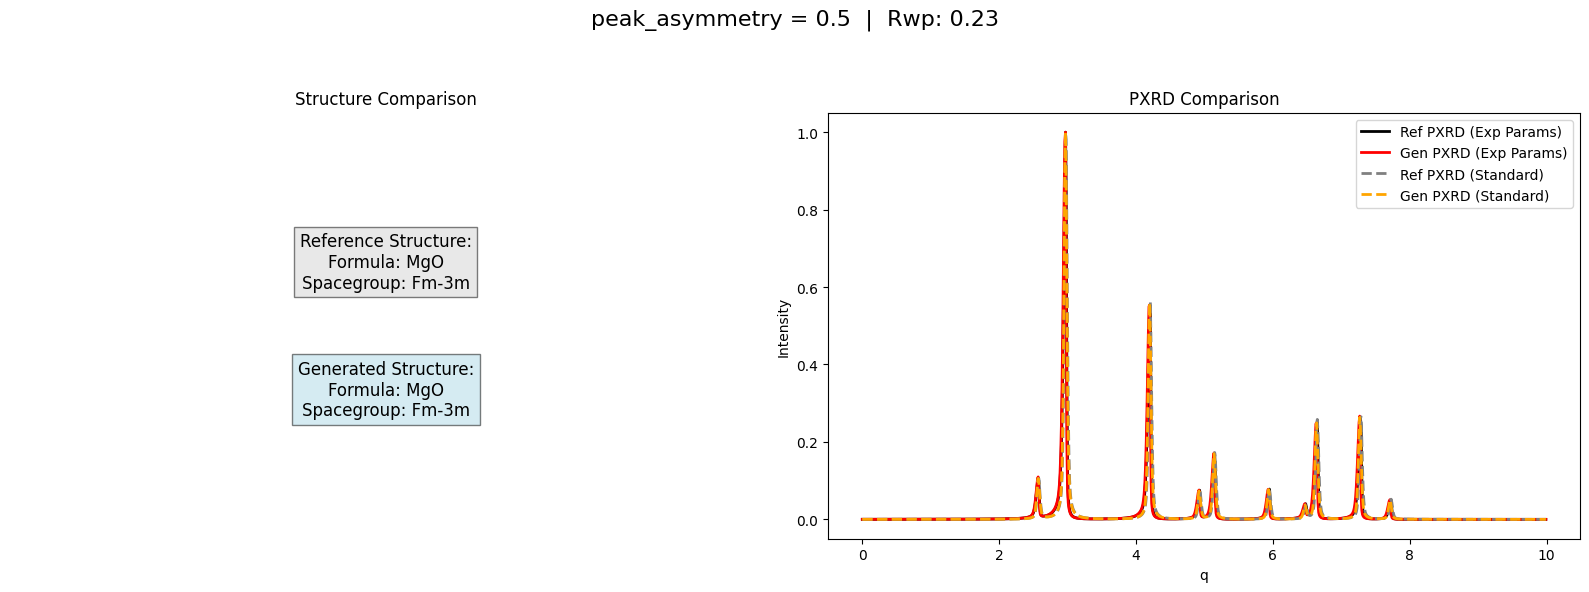

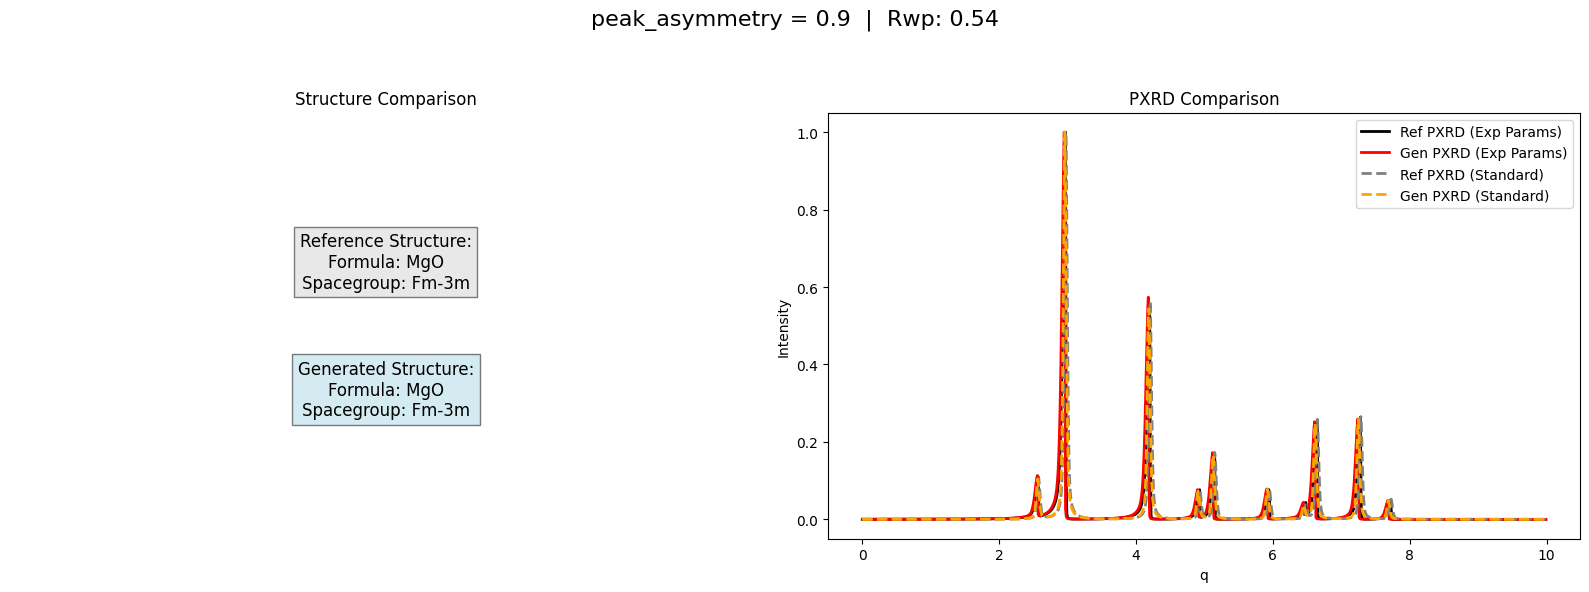

In [15]:
combined_analysis_and_visualization("../peak_asym_experimental_results_compsg.pkl",
                                    "peak_asymmetry", prefix="compsg", folder="peak_asymmetry")